In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def _read_jhu_csv(path, datatype, us_or_global):
    """
    Function for reading an individual JHU data file and returning
    a Pandas DataFrame with desired format.

    """

    jhu_csv = pd.read_csv(path)

    if us_or_global == "us":

        jhu_us_remove_columns = ['UID', 'iso2', 'iso3', 'code3', 'Combined_Key']
        if 'Population' in jhu_csv.keys():
            jhu_us_remove_columns.append('Population')
        jhu_csv.drop(columns=jhu_us_remove_columns, inplace=True)

        jhu_us_rename_columns = {
            "FIPS": "fips",
            "Admin2": "county",
            "Province_State": "state",
            "Country_Region": "country",
            "Lat": "lat",
            "Long_": "long",
        }

        jhu_csv.rename(columns=jhu_us_rename_columns, inplace=True)

        timestamp = {d: pd.to_datetime(
            d,
            errors='ignore',
        ) for d in jhu_csv.keys() if d not in jhu_us_rename_columns.values()}

        jhu_csv.rename(columns=timestamp, inplace=True)

        jhu_us_keep_columns = ['fips', 'county', 'state', 'country', 'lat', 'long']

        if datatype == 'confirmed':
            jhu_csv = pd.melt(jhu_csv, id_vars=jhu_us_keep_columns, var_name='date', value_name='cases')
        elif datatype == 'deaths':
            jhu_csv = pd.melt(jhu_csv, id_vars=jhu_us_keep_columns, var_name='date', value_name='deaths')

    elif us_or_global == 'global':
        jhu_global_rename_columns = {
            "Province/State": "state",
            "Country/Region": "country",
            "Lat": "lat",
            "Long": "long",
        }

        jhu_csv.rename(columns=jhu_global_rename_columns, inplace=True)

        timestamp = {
            d: pd.to_datetime(
                d, errors='ignore',
            ) for d in jhu_csv.keys() if d not in jhu_global_rename_columns.values()
        }

        jhu_csv.rename(columns=timestamp, inplace=True)
        jhu_global_keep_columns = ['state', 'country', 'lat', 'long']
        if datatype == 'confirmed':
            jhu_csv = pd.melt(jhu_csv, id_vars=jhu_global_keep_columns, var_name='date', value_name='cases')
        elif datatype == 'deaths':
            jhu_csv = pd.melt(jhu_csv, id_vars=jhu_global_keep_columns, var_name='date', value_name='deaths')
        elif datatype == 'recovered':
            jhu_csv = pd.melt(jhu_csv, id_vars=jhu_global_keep_columns, var_name='date', value_name='recovered')

    return jhu_csv

def _merge_jhu_data(us_or_global):
    """Function for merging the JHU data to combine different source files."""

    if us_or_global == "us":
        jhu_paths = [
            "data/jhu/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv",
            "data/jhu/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv",
        ]

        jhu_datainfo = [p.lower().split('.')[0].split('_')[-2:] for p in jhu_paths]

        jhu_data = pd.merge(
            *[_read_jhu_csv(
                p,
                *datainfo,
            ) for p, datainfo in zip(
                jhu_paths,
                jhu_datainfo,
            )],
        )
    elif us_or_global == 'global':
        jhu_paths = [
            "data/jhu/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
            "data/jhu/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv",
            "data/jhu/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv",
        ]

        jhu_datainfo = [p.lower().split('.')[0].split('_')[-2:] for p in jhu_paths]

        for ii in range(len(jhu_paths)):
            if ii == 0:
                jhu_data = _read_jhu_csv(jhu_paths[ii], *jhu_datainfo[ii])
            elif ii > 0:
                jhu_data = pd.merge(
                    jhu_data,
                    _read_jhu_csv(jhu_paths[ii], *jhu_datainfo[ii]),
                )
    
    return jhu_data

def _get_jhu_data():
    """Function for reading all JHU data and returning a Pandas DataFrame."""

    jhu_data = pd.concat(
        (_merge_jhu_data('us'), _merge_jhu_data('global')), ignore_index=True, sort=False,
    )

    return jhu_data

def _get_nytimes_data():
    """Function for reading the NYTimes data and returning a Pandas DataFrame."""

    nytimes_data = pd.read_csv("data/nytimes/us-counties.csv")
    nytimes_data['date'] = pd.to_datetime(nytimes_data['date'])

    return nytimes_data

In [5]:
df_jhu = _get_jhu_data()
df_nytimes = _get_nytimes_data()

(1, 100000.0)

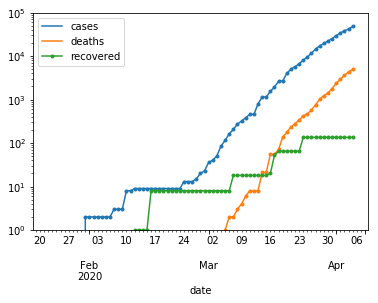

In [189]:
ax = df_jhu[(df_jhu.country == 'United Kingdom') & (df_jhu.state.isna())].plot(
    'date', 'cases', marker='.',
)
ax = df_jhu[(df_jhu.country == 'United Kingdom') & (df_jhu.state.isna())].plot(
    'date', 'deaths', marker='.', ax=ax,
)
ax = df_jhu[(df_jhu.country == 'United Kingdom') & (df_jhu.state.isna())].plot(
    'date', 'recovered', marker='.', ax=ax,
)
plt.yscale('log')
plt.ylim(1, 1e5)

(1, 100000.0)

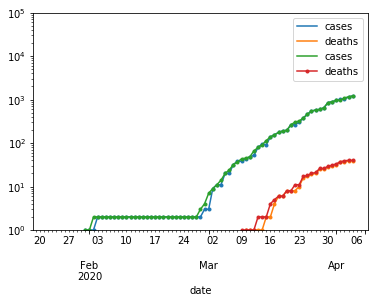

In [10]:
df_jhu = _merge_jhu_data('us')
ax = df_jhu[df_jhu.county=='Santa Clara'].plot('date', 'cases', marker='.')
ax = df_jhu[df_jhu.county=='Santa Clara'].plot('date', 'deaths', marker='.', ax=ax)
ax = df_nytimes[df_nytimes.county=='Santa Clara'].plot('date', 'cases', marker='.',ax=ax)
ax = df_nytimes[df_nytimes.county=='Santa Clara'].plot('date', 'deaths', marker='.', ax=ax)
plt.yscale('log')
plt.ylim(1, 1e5)

(1, 100000.0)

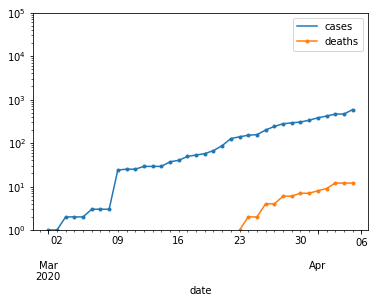

In [6]:
ax = df_nytimes[df_nytimes.county=='Alameda'].plot('date', 'cases', marker='.')
df_nytimes[df_nytimes.county=='Alameda'].plot('date', 'deaths', marker='.', ax=ax)
plt.yscale('log')
plt.ylim(1, 1e5)